In [2]:
import pandas as pd
import numpy as np
import janitor
import gc
import time
import matplotlib.pyplot as plt

In [122]:
state = 'utah'

# get voting age pop 

# read in cities
if state == 'california':
    path = '../data/VM2--CA--2022-04-25/'
    df_cities = pd.read_csv(path + 'ca-cities.csv')
    # replace El Paso de Robles with Paso Robles:
    df_cities.loc[df_cities['city'] == 'El Paso de Robles', 'city'] = 'Paso Robles'
elif state == 'utah':
    path = '../data/VM2--UT--2022-03-30/'
    df_cities = pd.read_csv(path + 'ut-cities.csv')
    # replace...
    df_cities.loc[df_cities['city'] == 'St. George', 'city'] = 'Saint George'
    df_cities = df_cities.dropna(subset=['population_proper'])
else:
    df_cities = pd.read_csv(path + 'cities.csv')


# make new column w/ voter_population, that is total population * percent20+
def calculate_voter_pop(row):
    percent_voting_age = row[['age_20s','age_30s', 'age_40s', 'age_50s', 'age_60s', 
                              'age_70s', 'age_over_80']].sum() / 100
    return int(np.floor(row['population_proper'] * percent_voting_age))

df_cities['voter_population'] = df_cities.apply(lambda row: calculate_voter_pop(row), axis=1)
df_cities.head()

RCV              city        city_ascii      city_alt state_id state_name  \
0  1.0    Salt Lake City    Salt Lake City           NaN       UT       Utah   
1  NaN             Ogden             Ogden           NaN       UT       Utah   
2  NaN             Provo             Provo           NaN       UT       Utah   
3  NaN  West Valley City  West Valley City           NaN       UT       Utah   
4  NaN      Saint George        St. George  Saint George       UT       Utah   

   county_fips county_name  county_fips_all county_name_all  ...  race_other  \
0      49035.0   Salt Lake          49035.0       Salt Lake  ...        12.8   
1      49057.0       Weber          49057.0           Weber  ...         7.1   
2      49049.0        Utah          49049.0            Utah  ...         2.6   
3      49035.0   Salt Lake          49035.0       Salt Lake  ...        25.0   
4      49053.0  Washington          49053.0      Washington  ...         4.6   

   race_multiple  hispanic  disabled  poverty limited_english commute_time  \
0            3.1      21.3      10.6     17.8             4.9         19.4   
1            3.9      32.3      13.0     21.4             4.1         20.3   
2            3.6      16.3       8.3     25.4             3.4         17.8   
3            4.3      37.7       9.4     13.8             7.6         22.0   
4            2.8      13.0      13.8     15.5             2.1         15.0   

  health_uninsured veteran voter_population  
0             14.6     4.7           152613  
1             17.1     7.8            60921  
2             11.8     2.5            83542  
3             20.8     5.4            89055  
4             13.9     8.6            60096  

[5 rows x 83 columns]

Combine with merged file:

In [123]:
# read in merged file
merged_file = pd.read_csv(f'{path}voter_turnout_merged_{state}.csv')
merged_file.head()

Residence_Addresses_City   elec_date  elec_year             elec_type  \
0             Brigham City  2020_11_03       2020               General   
1             Brigham City  2018_11_06       2018               General   
2             Brigham City  2016_11_08       2016               General   
3             Brigham City  2014_11_04       2014               General   
4             Brigham City  2019_11_05       2019  Consolidated_General   

   total_voters_asian  total_voters_black  total_voters_hispanic  \
0               104.0                 NaN                  524.0   
1               104.0                 NaN                  524.0   
2               104.0                 NaN                  524.0   
3               104.0                 NaN                  524.0   
4               104.0                 NaN                  524.0   

   total_voters_white  voted_voters_asian  voted_voters_black  ...  \
0              8553.0                89.0                 NaN  ...   
1              8553.0                57.0                 NaN  ...   
2              8553.0                62.0                 NaN  ...   
3              8553.0                21.0                 NaN  ...   
4              8553.0                23.0                 NaN  ...   

   perc_turnout_income_$50000-74999  perc_turnout_income_$75000-99999  \
0                          0.808653                          0.835677   
1                          0.572283                          0.611892   
2                          0.578614                          0.629972   
3                          0.257826                          0.293692   
4                          0.273303                          0.292085   

   CommercialData_EstimatedHHIncomeAmount  total_voters_college  \
0                            85141.696468                4077.0   
1                            85141.696468                4077.0   
2                            85141.696468                4077.0   
3                            85141.696468                4077.0   
4                            85141.696468                4077.0   

   total_voters_no_college  voted_voters_college  voted_voters_no_college  \
0                   2106.0                3657.0                   1866.0   
1                   2106.0                2846.0                   1518.0   
2                   2106.0                2985.0                   1534.0   
3                   2106.0                1466.0                    804.0   
4                   2106.0                1494.0                    814.0   

   perc_turnout_college  perc_turnout_no_college   mean_age  
0              0.896983                 0.886040  53.145914  
1              0.698062                 0.720798  57.152151  
2              0.732156                 0.728395  57.166180  
3              0.359578                 0.381766  64.762912  
4              0.366446                 0.386515  62.947498  

[5 rows x 63 columns]

In [125]:
# check number of cities in merged file
merged_file['Residence_Addresses_City'].nunique()

47

In [126]:
# merge with voter_population counts
merged_file = merged_file.merge(df_cities[['city', 'voter_population']], how = 'inner', left_on = ['Residence_Addresses_City'], right_on = ['city'])
merged_file.drop(columns=['city'], inplace=True)
merged_file.head()

Residence_Addresses_City   elec_date  elec_year             elec_type  \
0             Brigham City  2020_11_03       2020               General   
1             Brigham City  2018_11_06       2018               General   
2             Brigham City  2016_11_08       2016               General   
3             Brigham City  2014_11_04       2014               General   
4             Brigham City  2019_11_05       2019  Consolidated_General   

   total_voters_asian  total_voters_black  total_voters_hispanic  \
0               104.0                 NaN                  524.0   
1               104.0                 NaN                  524.0   
2               104.0                 NaN                  524.0   
3               104.0                 NaN                  524.0   
4               104.0                 NaN                  524.0   

   total_voters_white  voted_voters_asian  voted_voters_black  ...  \
0              8553.0                89.0                 NaN  ...   
1              8553.0                57.0                 NaN  ...   
2              8553.0                62.0                 NaN  ...   
3              8553.0                21.0                 NaN  ...   
4              8553.0                23.0                 NaN  ...   

   perc_turnout_income_$75000-99999  CommercialData_EstimatedHHIncomeAmount  \
0                          0.835677                            85141.696468   
1                          0.611892                            85141.696468   
2                          0.629972                            85141.696468   
3                          0.293692                            85141.696468   
4                          0.292085                            85141.696468   

   total_voters_college  total_voters_no_college  voted_voters_college  \
0                4077.0                   2106.0                3657.0   
1                4077.0                   2106.0                2846.0   
2                4077.0                   2106.0                2985.0   
3                4077.0                   2106.0                1466.0   
4                4077.0                   2106.0                1494.0   

   voted_voters_no_college  perc_turnout_college  perc_turnout_no_college  \
0                   1866.0              0.896983                 0.886040   
1                   1518.0              0.698062                 0.720798   
2                   1534.0              0.732156                 0.728395   
3                    804.0              0.359578                 0.381766   
4                    814.0              0.366446                 0.386515   

    mean_age  voter_population  
0  53.145914             13197  
1  57.152151             13197  
2  57.166180             13197  
3  64.762912             13197  
4  62.947498             13197  

[5 rows x 64 columns]

In [127]:
merged_file['Residence_Addresses_City'].nunique()

47

### Graphing

In [19]:
# one graph, with average voter turnout per election type
# read in new merged file for CA
path = '../data/VM2--CA--2022-04-25/'
data = pd.read_csv(path + 'voter_turnout_merged_CA.csv')

data['overall_turnout_perc'] = data['voted_voters'] / data['voter_population']

# group by election type, get average overall_turnout_perc

avg_turnout = data.groupby(['elec_type']).mean()['overall_turnout_perc']
avg_turnout

elec_type
Consolidated_General    0.047212
General                 0.434623
Local_or_Municipal      0.052554
Name: overall_turnout_perc, dtype: float64

<AxesSubplot:title={'center':'Overall turnout per election type'}, xlabel='Election type', ylabel='percent turnout'>

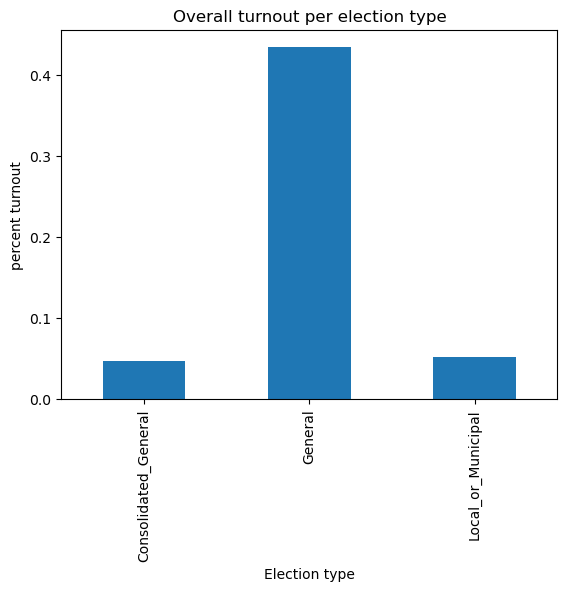

In [20]:
# graph anyway
avg_turnout.plot.bar(title='Overall turnout per election type', xlabel='Election type', ylabel='percent turnout')

In [22]:
data.head()

Residence_Addresses_City   elec_date  elec_year             elec_type  \
0                  Oakland  2020_11_03       2020               General   
1                  Oakland  2018_11_06       2018               General   
2                  Oakland  2016_11_08       2016               General   
3                  Oakland  2014_11_04       2014               General   
4                  Oakland  2019_11_05       2019  Consolidated_General   

   total_voters_asian  total_voters_black  total_voters_hispanic  \
0             30600.0             61476.0                37174.0   
1             30600.0             61476.0                37174.0   
2             30600.0             61476.0                37174.0   
3             30600.0             61476.0                37174.0   
4             30600.0             61476.0                37174.0   

   total_voters_others  total_voters_white  voted_voters_asian  ...  \
0               8628.0             83122.0             23041.0  ...   
1               8628.0             83122.0             14972.0  ...   
2               8628.0             83122.0             16057.0  ...   
3               8628.0             83122.0              8145.0  ...   
4               8628.0             83122.0               320.0  ...   

   total_voters_college  total_voters_no_college  voted_voters_college  \
0               80668.0                  27989.0               71356.0   
1               80668.0                  27989.0               59248.0   
2               80668.0                  27989.0               60766.0   
3               80668.0                  27989.0               38216.0   
4               80668.0                  27989.0                1076.0   

   voted_voters_no_college  perc_turnout_college  perc_turnout_no_college  \
0                  22543.0             88.456389                80.542356   
1                  17372.0             73.446720                62.067241   
2                  18951.0             75.328507                67.708743   
3                  10811.0             47.374424                38.625889   
4                    177.0              1.333862                 0.632391   

    mean_age  voter_population  voted_voters  overall_turnout_perc  
0  47.829424            331652      172221.0              0.519282  
1  48.224196            331652      130249.0              0.392728  
2  46.819512            331652      135633.0              0.408962  
3  51.034918            331652       75153.0              0.226602  
4  36.245383            331652        2319.0              0.006992  

[5 rows x 69 columns]

In [23]:
# separate data into RCV and non-RCV
RCV_cities_CA = ['San Francisco',
     'Oakland',
     'Berkeley',
     'San Leandro',
     'Palm Desert',
     'Eureka',
     'Albany']

nonRCV_cities_CA = ['Fresno',
     'San Diego',
     'Sacramento',
     'Riverside',
     'San Jose',
     'Santa Ana',
     'Anaheim',
     'Santa Rosa',
     'Merced',
     'Santa Clarita',
     'Alhambra',
     'Davis',
     'Montebello',
     'Burbank',
     'Huntington Park',
     'Bellflower',
     'Watsonville',
     'Gilroy',
     'Whittier',
     'Lynwood',
     'Lakewood',
     'Pico Rivera',
     'Lake Forest',
     'Livermore',
     'Chino Hills',
     'Paramount',
     'El Paso de Robles',
     'Pico Rivera',
     'Buena Park',
     'Whittier',
     'Calabasas',
     'Carpinteria',
     'Morro Bay',
     'San Carlos',
     'Solvang']


data_RCV = data[data['Residence_Addresses_City'].isin(RCV_cities_CA)]
data_nonRCV = data[data['Residence_Addresses_City'].isin(nonRCV_cities_CA)]
print(data_RCV.shape)
print(data_nonRCV.shape)

(48, 69)
(208, 69)


In [24]:
# get averages
avg_turnout_RCV = data_RCV.groupby(['elec_type']).mean()['overall_turnout_perc']
avg_turnout_nonRCV = data_nonRCV.groupby(['elec_type']).mean()['overall_turnout_perc']

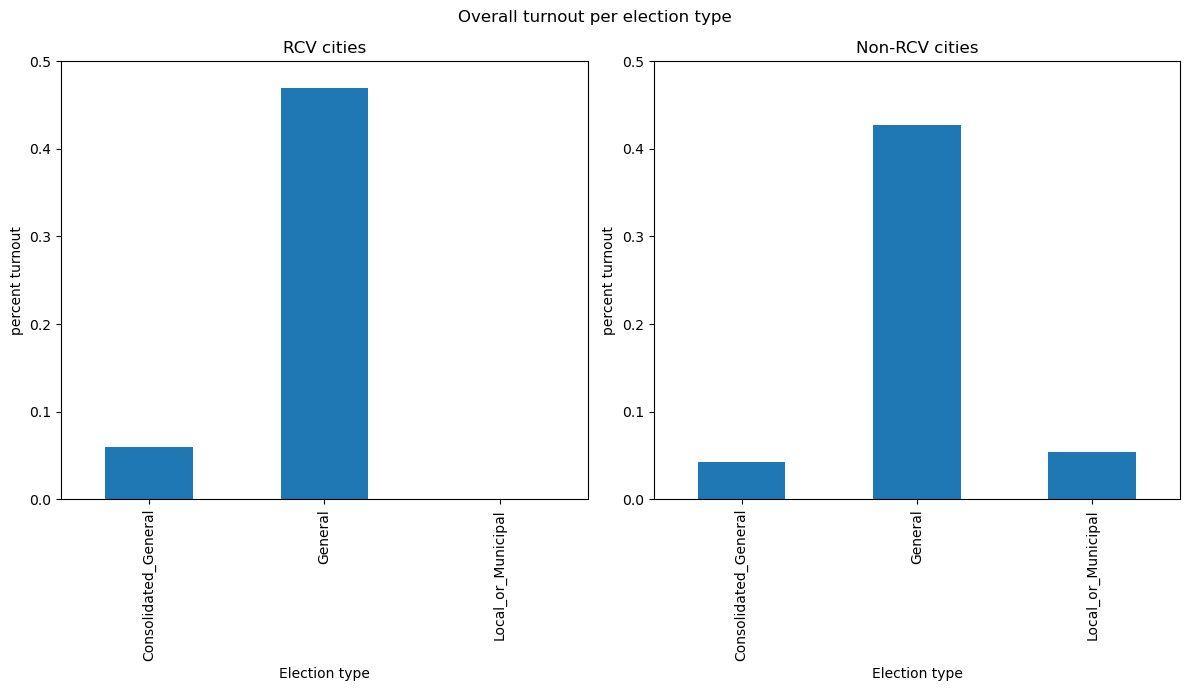

In [41]:
# subplots w both
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Overall turnout per election type')
fig.set_size_inches(12, 7)
avg_turnout_RCV.plot.bar(title='RCV cities', xlabel='Election type', ylabel='percent turnout', ax=ax1, ylim=[0,0.5])
avg_turnout_nonRCV.plot.bar(title='Non-RCV cities', xlabel='Election type', ylabel='percent turnout', ax=ax2, ylim=[0,0.5])
fig.tight_layout()
